## Read in the data in wide format

In [2]:
from Datapreprocessing import DataProcessor, TrainModel, evaluate_regression_model
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

In [3]:
train_folder = 'train_tsv1'
test_folder = 'test_tsv1'
train_metadata_path = 'metadata/training_metadata.csv'
test_metadata_path = 'metadata/test_metadata.csv'

In [4]:
processor = DataProcessor(train_folder, test_folder, train_metadata_path, test_metadata_path)
train_data, test_data = processor.prepare_datasets(wide_format=True)

In [5]:
train_data.head()

,participant_id,corr_1,corr_2,corr_3,corr_4,corr_5,corr_6,corr_7,corr_8,corr_9,...,bmi,ethnicity,race,handedness,parent_1_education,parent_2_education,p_factor_fs,internalizing_fs,externalizing_fs,attention_fs
0,NDAREE015WGU,0.074628,0.673757,0.813541,0.725489,0.823861,0.801859,0.690204,0.450536,0.602295,...,19.10,Not_Hispanic_or_Latino,Other,Right,Complete_tertiary,Complete_tertiary,0.59,-0.15,0.29,-1.60
1,NDARNV694EMG,0.167241,0.549381,0.453434,0.132590,0.496156,0.337475,0.506641,0.215110,0.564849,...,32.46,Not_Hispanic_or_Latino,White,Right,Complete_primary,Complete_tertiary,-0.17,0.54,-1.00,-0.87
2,NDARFR108JNB,0.197198,0.337779,0.018934,0.580793,0.728406,0.507803,0.470236,0.401553,0.547191,...,15.98,Hispanic_or_Latino,Other,Right,Complete_tertiary,Complete_tertiary,-0.43,-0.25,0.18,0.39
3,NDARZF170TZ0,0.370992,0.546226,0.659874,0.212565,0.429793,0.352411,0.047157,0.112740,0.012267,...,14.92,Not_Hispanic_or_Latino,Other,Right,Complete_primary,Complete_tertiary,-0.33,0.25,-0.31,1.10
4,NDARYJ334EHH,0.127956,0.415074,0.219740,0.311787,0.650690,0.615524,0.597610,0.334451,0.327396,...,18.85,Hispanic_or_Latino,NaN,Right,NaN,No_incomplete primary,-1.04,-0.40,-0.53,0.71


In [6]:
# train_data.to_csv('train_data_wide.csv', index=False)
# test_data.to_csv('test_data_wide.csv', index=False)

## Fill in the missing values

In [24]:
train_data = pd.read_csv('train_data_wide.csv')

In [25]:
# Replace missing BMI values with 0
train_data['bmi'] = train_data['bmi'].fillna(0)

# Replace missing values in categorical columns with "not recorded"
categorical_columns = ['ethnicity', 'race', 'parent_1_education', 'parent_2_education']
train_data[categorical_columns] = train_data[categorical_columns].fillna("not recorded")

## Fit the linear regression model

Using direct model (no encoding needed)


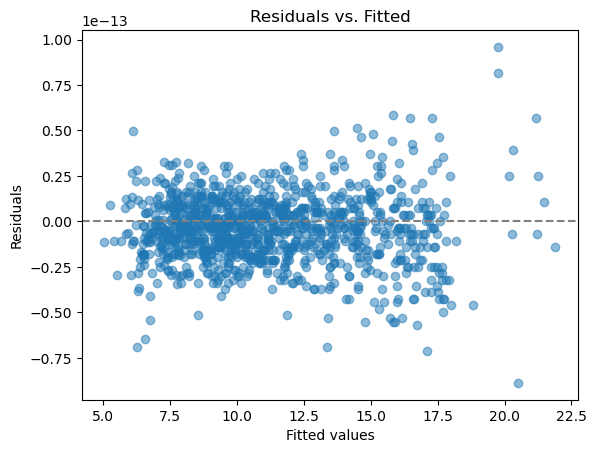

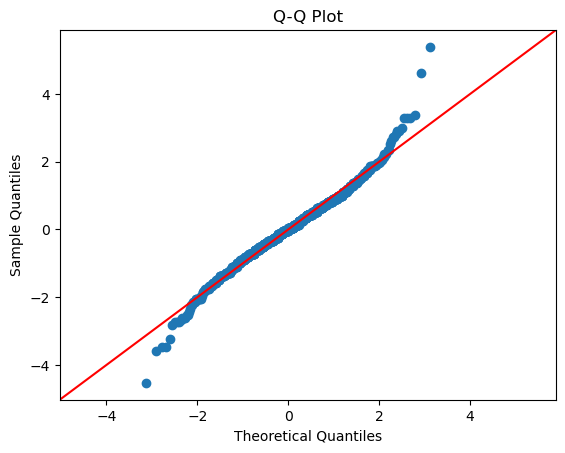


Cross-Validation Results:
Train R² Scores: [1. 1. 1. 1. 1.]
Mean Train R² Score: 1.0000
Test R² Scores: [0.58182988 0.58807993 0.61371797 0.57568561 0.51944486]
Mean Test R² Score: 0.5758
Test MSE Scores: [4.19206491 3.83296039 4.03925791 4.68833666 5.43818445]
Mean Test MSE: 4.4382


In [26]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression
import numpy as np

X = train_data.drop(['age', 'participant_id', 'ethnicity', 'race', 'handedness', 
                     'parent_1_education', 'parent_2_education', 'sex', 'study_site'], axis=1)  
y = train_data['age']

evaluate_regression_model(X, y)

Using target encoding pipeline


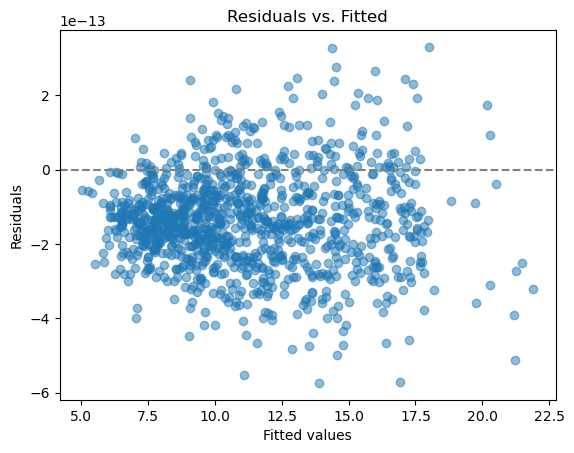

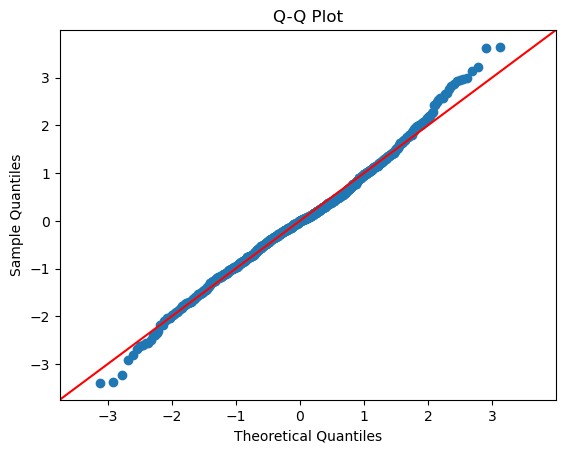


Cross-Validation Results:
Train R² Scores: [1. 1. 1. 1. 1.]
Mean Train R² Score: 1.0000
Test R² Scores: [0.58549926 0.60294436 0.61109846 0.5787358  0.52079393]
Mean Test R² Score: 0.5798
Test MSE Scores: [4.15528009 3.69464526 4.06664946 4.65463449 5.4229177 ]
Mean Test MSE: 4.3988


In [27]:
X = train_data.drop(['age'], axis=1)  
y = train_data['age']

evaluate_regression_model(X, y)

Based on the two linear regression models fitted above, there is serious overfitting problems, but the results showed that adding categorical variables may not bring much improvement to the model performance.

## Select Features

In [11]:
from sklearn.feature_selection import SelectKBest, f_regression

object_columns = train_data.select_dtypes(include=['object']).columns
correlation_features = train_data.drop(columns=object_columns)
target = train_data['age']
selector = SelectKBest(f_regression, k=100)
features_reduced = selector.fit_transform(correlation_features, target)

In [12]:
features_reduced = pd.DataFrame(features_reduced, columns=correlation_features.columns[selector.get_support()])
features_reduced.head()

,corr_4440,corr_6700,corr_6701,corr_6805,corr_7055,corr_7062,corr_7070,corr_7231,corr_7278,corr_7279,...,corr_18761,corr_18763,corr_18869,corr_18897,corr_19391,corr_19392,corr_19422,corr_19796,age,bmi
0,-0.121599,0.155337,0.141229,0.124573,-0.368117,-0.199834,-0.295317,-0.248700,0.258086,0.154537,...,-0.292097,-0.367697,-0.193657,-0.100102,-0.268719,-0.184924,0.133518,0.232407,13.35,19.10
1,-0.047480,0.108901,0.096683,0.117455,-0.125318,-0.032815,-0.298915,0.042610,-0.068114,0.017172,...,-0.156705,-0.422065,-0.207533,0.052250,-0.402520,-0.228050,-0.153885,0.235959,14.62,32.46
2,-0.009281,0.067010,0.032118,0.020547,-0.469052,-0.148011,0.215291,0.111302,-0.051266,0.027710,...,-0.207746,-0.151859,-0.435711,0.092661,0.063883,0.120454,0.051956,0.036671,7.14,15.98
3,0.331472,0.309834,0.122446,0.267139,-0.293554,-0.205999,-0.333704,-0.088601,-0.020188,0.279073,...,-0.023780,-0.337322,-0.097995,0.278202,-0.117643,0.211957,-0.095803,0.323449,13.94,14.92
4,0.252408,0.072247,-0.041780,0.261419,-0.206515,-0.449440,-0.673377,0.132281,-0.273004,0.367468,...,0.091789,-0.238256,0.058237,0.191942,-0.291110,-0.056419,0.138968,0.419641,9.92,18.85


Using direct model (no encoding needed)


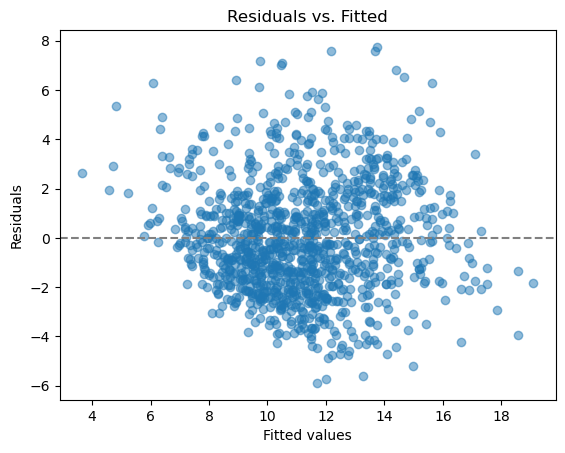

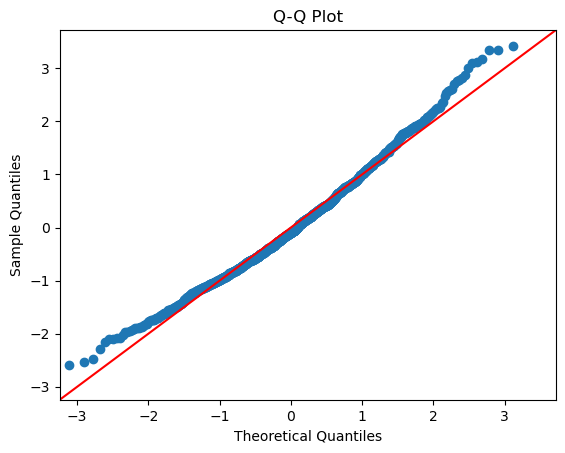


Cross-Validation Results:
Train R² Scores: [0.53108023 0.50991777 0.50846324 0.53110005 0.53125405]
Mean Train R² Score: 0.5224
Test R² Scores: [0.33968693 0.44182166 0.44037982 0.34225105 0.33337477]
Mean Test R² Score: 0.3795
Test MSE Scores: [6.61949547 5.19390924 5.85181303 7.2676029  7.54383965]
Mean Test MSE: 6.4953


In [13]:
X = features_reduced.drop(['age'], axis=1)  
y = features_reduced['age']

evaluate_regression_model(X, y)

## Select Features Using PCA

In [14]:
import category_encoders as ce

X = train_data.drop(['age', 'participant_id'], axis=1)  
y = train_data['age']
encoder = ce.TargetEncoder()
encoder.fit(X, y)
X_encoded = encoder.transform(X)
X_encoded.head()

,corr_1,corr_2,corr_3,corr_4,corr_5,corr_6,corr_7,corr_8,corr_9,corr_10,...,bmi,ethnicity,race,handedness,parent_1_education,parent_2_education,p_factor_fs,internalizing_fs,externalizing_fs,attention_fs
0,0.074628,0.673757,0.813541,0.725489,0.823861,0.801859,0.690204,0.450536,0.602295,0.414038,...,19.10,11.131882,11.314095,11.254486,11.059057,11.077816,0.59,-0.15,0.29,-1.60
1,0.167241,0.549381,0.453434,0.132590,0.496156,0.337475,0.506641,0.215110,0.564849,0.303428,...,32.46,11.131882,10.982736,11.254486,11.175368,11.077816,-0.17,0.54,-1.00,-0.87
2,0.197198,0.337779,0.018934,0.580793,0.728406,0.507803,0.470236,0.401553,0.547191,0.515227,...,15.98,11.046714,11.314095,11.254486,11.059057,11.077816,-0.43,-0.25,0.18,0.39
3,0.370992,0.546226,0.659874,0.212565,0.429793,0.352411,0.047157,0.112740,0.012267,0.018085,...,14.92,11.131882,11.314095,11.254486,11.175368,11.077816,-0.33,0.25,-0.31,1.10
4,0.127956,0.415074,0.219740,0.311787,0.650690,0.615524,0.597610,0.334451,0.327396,0.489721,...,18.85,11.046714,11.560893,11.254486,11.381257,11.274087,-1.04,-0.40,-0.53,0.71


In [15]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA

# First standardize the data (important for PCA)
X_scaled = StandardScaler().fit_transform(X_encoded)
y_scaled = StandardScaler().fit_transform(y.values.reshape(-1, 1))

# Create PCA object without specifying components yet
pca = IncrementalPCA(batch_size=1500)  # Process 500 samples at a time

# Fit the PCA model to your data
pca.fit(X_scaled)

IncrementalPCA(batch_size=1500)

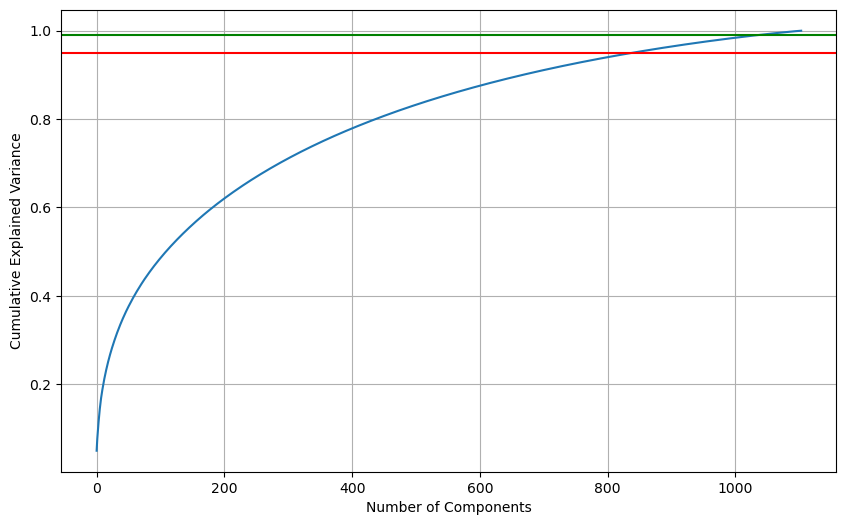

Components needed for 95% variance: 840


In [16]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='-')  # 95% line
plt.axhline(y=0.99, color='g', linestyle='-')  # 99% line
plt.grid(True)
plt.show()

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Components needed for 95% variance: {n_components_95}")

In [17]:
X_reduced = pca.transform(X_scaled)[:, :n_components_95]
X_reduced = pd.DataFrame(
    data=X_reduced,
    columns=[f'PC{i+1}' for i in range(X_reduced.shape[1])],
    index=X_scaled.index if hasattr(X_scaled, 'index') else None  # Preserve original index if available
)

# View the result
print(X_reduced.shape)
X_reduced.head()

(1104, 840)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC831,PC832,PC833,PC834,PC835,PC836,PC837,PC838,PC839,PC840
0,-37.068134,-19.582565,35.544210,13.445808,-19.090505,10.379657,-5.581700,-8.923754,27.321164,-8.603528,...,3.237457,2.345626,-2.689035,-1.391718,-3.748583,0.340000,1.171931,-1.645229,-4.355993,1.545033
1,-16.758704,1.568385,-13.399482,26.685071,15.917656,8.755840,9.910632,-5.388729,-21.162011,-1.066427,...,0.149876,2.162482,-1.871367,-1.869846,4.248890,-0.720395,-2.113292,-1.447469,1.340731,-0.480506
2,-8.889134,-11.989003,-14.101080,-15.018634,19.143247,34.273626,9.479018,10.815803,-1.111830,2.543403,...,-2.079910,-0.459527,1.130555,0.469860,-0.165825,1.299294,1.814806,-1.804568,0.239455,1.454267
3,-30.915280,1.171641,11.329445,11.922279,0.081204,14.325648,-4.287194,-14.593914,22.089838,-5.193443,...,6.828278,0.814900,-0.943709,-0.200728,1.130895,-4.094303,0.029580,2.217739,0.337331,-0.867393
4,-29.350947,60.884459,-9.589211,-31.376408,3.002276,-32.680036,23.388874,-18.001697,4.428919,13.123581,...,3.547522,0.190684,-1.767014,-1.273750,-2.616122,-3.112580,0.475397,3.601712,2.619591,4.182409


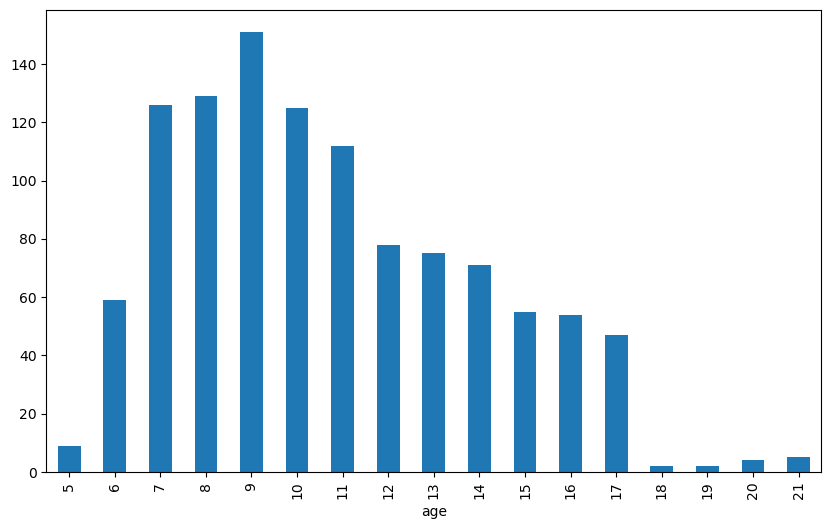

In [23]:
# combine X_reduced with y into a single DataFrame
X_reduced['age'] = y.values
X_reduced['age'] = X_reduced['age'].astype(int)  # Convert age to integer type
X_reduced['age'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6))
X_reduced.to_csv('df_PCA.csv', index=False)

Using direct model (no encoding needed)


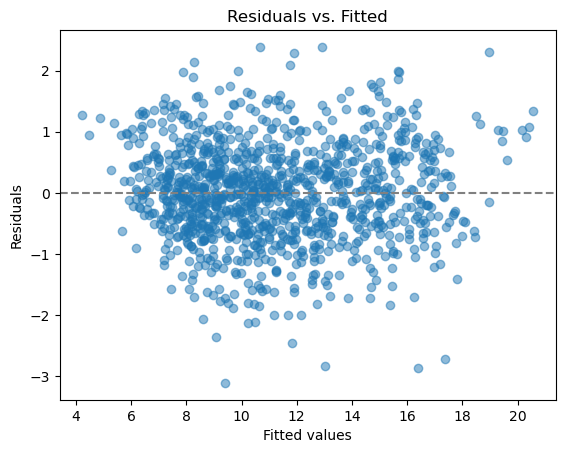

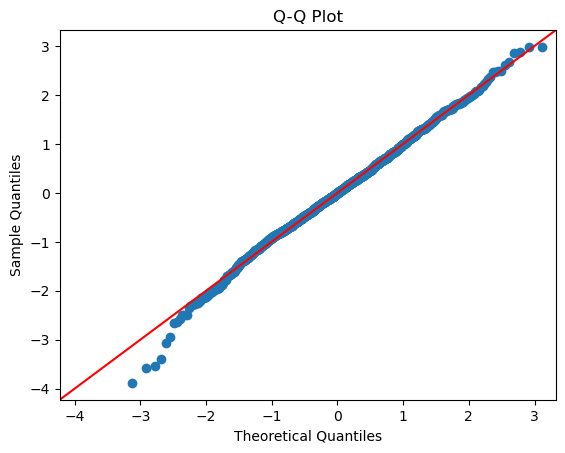


Cross-Validation Results:
Train R² Scores: [0.98814649 0.98702492 0.98928304 0.98619945 0.99221476]
Mean Train R² Score: 0.9886
Test R² Scores: [ -7.86967801  -6.70225223 -10.18207179  -6.19219177  -5.07069905]
Mean Test R² Score: -7.2034
Test MSE Scores: [ 88.91660058  71.67028177 116.92822433  79.46800026  68.6988407 ]
Mean Test MSE: 85.1364


In [23]:
evaluate_regression_model(X_reduced, y)

The testing R^2 showed negative results, which means that the linear regression does not fit well. We should consider ridge or lasso.

In [19]:
from sklearn.linear_model import Lasso

evaluate_regression_model(X_reduced, y, model_type=Lasso)

Using direct model (no encoding needed)

Cross-Validation Results:
Train R² Scores: [0.56402127 0.56937606 0.55271682 0.57064099 0.57061142]
Mean Train R² Score: 0.5655
Test R² Scores: [0.49617257 0.48269421 0.54867526 0.51186744 0.49300592]
Mean Test R² Score: 0.5065
Test MSE Scores: [5.05076088 4.81358578 4.7193938  5.39347669 5.73737974]
Mean Test MSE: 5.1429


In [ ]:
lasso = TrainModel(random_state=724)
metrics, model = lasso.run(X_reduced, y)

Best alpha value: 0.29470517025518095

--- Model Evaluation Results ---
Lasso - R² Train: 0.7678, R² Test: 0.6035, MSE Test: 3.9752


Let's try hypertuned XGBoost model and see if the results improved.

In [21]:
xgb = TrainModel(random_state=724)
metrics, model = xgb.run(X_reduced, y)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 1
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 200
n_resources: 1
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
----------
iter: 1
n_candidates: 67
n_resources: 3
Fitting 5 folds for each of 67 candidates, totalling 335 fits
----------
iter: 2
n_candidates: 23
n_resources: 9
Fitting 5 folds for each of 23 candidates, totalling 115 fits
----------
iter: 3
n_candidates: 8
n_resources: 27
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 3
n_resources: 81
Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7, 'booster': 'gbtree', 'n_estimators': 81}

--- Model Evaluation Results ---
XGBoost - R² Train: 0.7958, R² Test: 0.3115, MSE Test: 6.9026


Calculating SHAP values...
Creating SHAP plots...


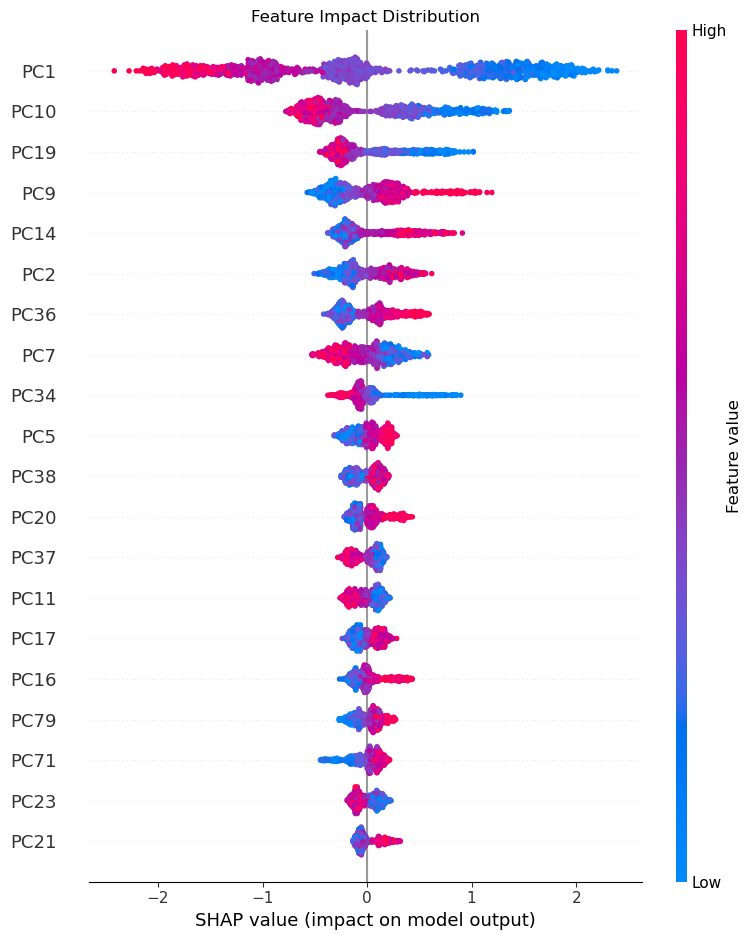

In [19]:
from Datapreprocessing import interpret_xgboost_with_shap
interpret_xgboost_with_shap(model, X_reduced)

## Try other models

### CPM

In [31]:
X = train_data.drop(['age', 'participant_id', 'ethnicity', 'race', 'handedness', 
                     'parent_1_education', 'parent_2_education', 'sex', 'study_site',
                     'bmi', 'p_factor_fs', 'internalizing_fs', 'externalizing_fs',
                     'attention_fs'], axis=1).values
y = train_data['age'].values

In [33]:
from Datapreprocessing import CPMTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score

# X: your (1104 × 19900) corr-matrix array, y: age vector
pipeline = Pipeline([
    ('cpm',    CPMTransformer(p_thresh=0.01)),
    ('reg',    Ridge(alpha=1.0))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    pipeline, X, y,
    cv=kf,
    scoring='r2',
    n_jobs=1
)

print("Fold R² scores:", np.round(scores, 3))
print("Mean CV R²:    ", np.round(scores.mean(), 3))

Fold R² scores: [0.361 0.319 0.295 0.42  0.303]
Mean CV R²:     0.34


In [37]:
X.shape

(1104, 19900)

### PLS + kernel ridge regression

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

from sklearn.cross_decomposition import PLSRegression

class PLS2(PLSRegression):
    """A PLS that in fit_transform only returns the X-scores."""
    def fit_transform(self, X, y=None, **fit_params):
        # 1) fit on (X,y)
        super().fit(X, y, **fit_params)
        # 2) return ONLY the X projections
        return super().transform(X)


inner_kf = KFold(5, shuffle=True, random_state=1)
outer_kf = KFold(5, shuffle=True, random_state=2)

pipe_pls_kr = Pipeline([
    ('scale', StandardScaler()),
    ('pls',   PLS2()),         # reduce to n_components first
    ('kr',    KernelRidge())
])

param_grid_pls_kr = {
    'pls__n_components': [20, 50, 100],
    'kr__kernel':         ['rbf'],
    'kr__alpha':          [0.1, 1.0, 10.0],
    'kr__gamma':          [1e-3, 1e-2]
}

grid_pls_kr = GridSearchCV(pipe_pls_kr, param_grid_pls_kr, cv=inner_kf, scoring='r2')
scores_pls_kr = cross_val_score(grid_pls_kr, X, y, cv=outer_kf, scoring='r2', n_jobs=1)

print("PLS→KernelRidge Nested CV R²:", scores_pls_kr.mean(), "±", scores_pls_kr.std())

/opt/anaconda3/envs/wids/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 88
  warnings.warn(f"y residual is constant at iteration {k}")
/opt/anaconda3/envs/wids/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 88
  warnings.warn(f"y residual is constant at iteration {k}")
/opt/anaconda3/envs/wids/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 88
  warnings.warn(f"y residual is constant at iteration {k}")
/opt/anaconda3/envs/wids/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 88
  warnings.warn(f"y residual is constant at iteration {k}")
/opt/anaconda3/envs/wids/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 88
  warnings.warn(f"y resid

PLS→KernelRidge Nested CV R²: -0.3145340391607051 ± 0.31149901117252576


### GNN